In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime

In [2]:
df = pd.read_csv('AirPassengers.csv')

In [3]:
df['Month'] = pd.to_datetime(df['Month'])
df =  df.set_index(['Month'])

In [4]:
df['Seasonal_yearly_Difference']=df['Passengers']-df['Passengers'].shift(12)

<AxesSubplot:xlabel='Month'>

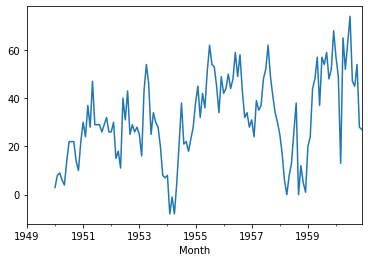

In [5]:
df['Seasonal_yearly_Difference'].plot()

### This time series is stationary

In [6]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

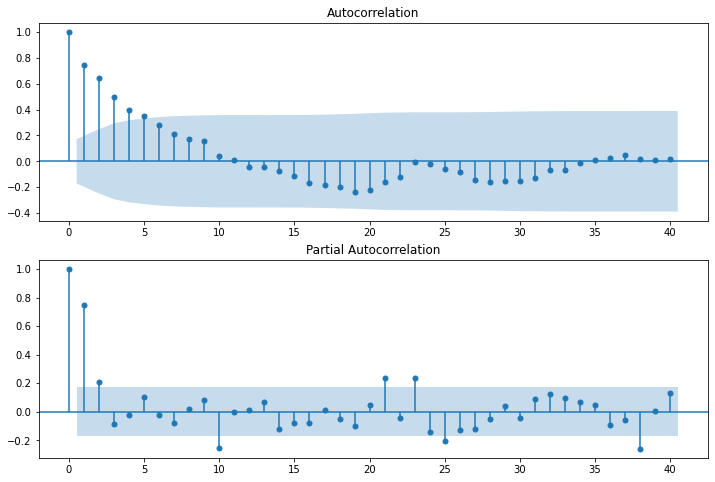

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal_yearly_Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal_yearly_Difference'].iloc[13:],lags=40,ax=ax2)

### AR model - p- PACF graph p=1,2,10
### MA model - q -ACF graph q=1,2,3,4 need to check while building ARIMA model

##### link: https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html

In [59]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

def MA_function(data,q,predict_m):
    a  = df.shape[0]
    train_data = data[0:a-predict_m]
    test_data =data[a-predict_m:]
    model1 = ARIMA(train_data, order=(0, 0, q))
    model_fit1 = model1.fit()
    # make prediction
    predictions = model_fit1.predict(start=len(train_data),end=len(train_data)+len(test_data)-1)
    compare_df = pd.concat(
        [df['Passengers'].tail(predict_m),
        predictions.apply(np.floor)], axis=1).rename(
        columns={'Passengers': 'actual', 0:'predicted'})
    #compare_df.plot()
    r2 = r2_score(df['Passengers'].tail(predict_m), predictions.apply(np.floor))
    #print(r2)
    return r2

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
for i in range(1,31):
    r = MA_function(df['Passengers'],i,6)
    r_val = round(r,2)
    print("r2_score for i {} is: {}  ".format(i,r_val))

r2_score for i 1 is: -5.19  
r2_score for i 2 is: -2.87  
r2_score for i 3 is: -1.75  
r2_score for i 4 is: -1.33  
r2_score for i 5 is: -0.82  
r2_score for i 6 is: 0.11  
r2_score for i 7 is: 0.77  
r2_score for i 8 is: 0.74  
r2_score for i 9 is: 0.48  
r2_score for i 10 is: -0.23  
r2_score for i 11 is: 0.85  
r2_score for i 12 is: -1.15  
r2_score for i 13 is: -0.13  
r2_score for i 14 is: 0.46  
r2_score for i 15 is: 0.68  
r2_score for i 16 is: 0.75  
r2_score for i 17 is: 0.86  
r2_score for i 18 is: 0.93  
r2_score for i 19 is: 0.93  
r2_score for i 20 is: 0.87  
r2_score for i 21 is: -1.45  
r2_score for i 22 is: 0.21  
r2_score for i 23 is: 0.24  
r2_score for i 24 is: 0.95  
r2_score for i 25 is: 0.59  
r2_score for i 26 is: 0.5  
r2_score for i 27 is: 0.72  
r2_score for i 28 is: -0.38  
r2_score for i 29 is: 0.98  
r2_score for i 30 is: -11.64  


### q = 11,17,18,19,20 gives good results

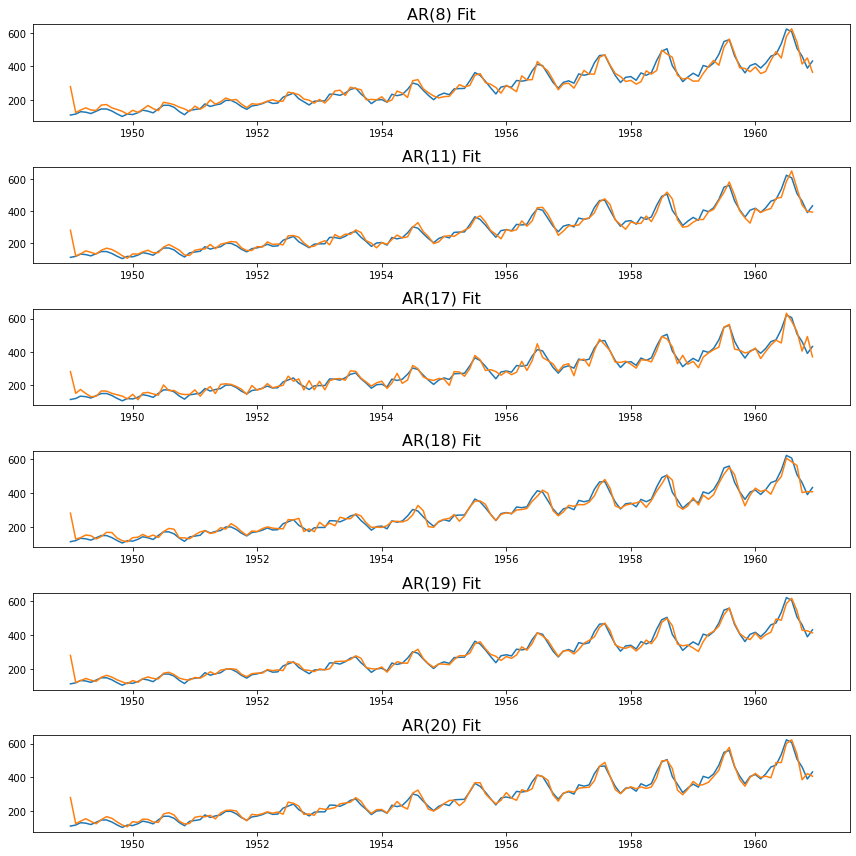

In [70]:
plt.figure(figsize=(12,12))
ar_orders = [8,11,17,18,19,20]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    
    #create AR(p) model
    ma_model = ARIMA(df['Passengers'], order=(0,0,ar_order))
    ma_model_fit = ma_model.fit()
    fitted_model_dict[ar_order] = ma_model_fit
    plt.subplot(6,1,idx+1)
    plt.plot(df['Passengers'])
    plt.plot(ma_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

In [71]:
#AIC comparison
for ar_order in ar_orders:
    print('AIC for MA(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for MA(8): 1386.5828885130898
AIC for MA(11): 1348.383208189874
AIC for MA(17): 1395.962311468893
AIC for MA(18): 1350.8941170388102
AIC for MA(19): 1310.7471600642937
AIC for MA(20): 1339.5015595916827


In [72]:
#BIC comparison
for ar_order in ar_orders:
    print('BIC for MA(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for MA(8): 1416.2810215088498
BIC for MA(11): 1386.990781084362
BIC for MA(17): 1452.388764160837
BIC for MA(18): 1410.2903830303303
BIC for MA(19): 1373.1132393553896
BIC for MA(20): 1404.8374521823548


###  MA(11) model can be selected by taking AIC , BIC and r2 into consideration